<a href="https://www.kaggle.com/code/rajanbirsingh/garbage-classification?scriptVersionId=126723967" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Rajanbir Singh 101413692
Sarthak Taneja 101394349

# Objective
This model which help us to classify waste with 7 different waste materials and it will show you the details of that particular waste materials. This will help to raise awareness for people to reduce and recycle waste.

# Overview
There are 'cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash' total 7 different types of waste materials which are use for recycling.
Here i have 2187 images belonging 7 classes.
Here i have trained dataset using VGG16,RESNET50 model via using Transfer Learning technique of CNN for classification.
Here i have trained this model till 5 epochs and i got 69.77% accuracy. Since my computer can not aford more epochs at this time due unavailbility of GPU. if you have good ammount of gpu you can train more than 50 epochs.

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import cv2
import sklearn
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
#from tf.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from PIL import Image as im
import cv2

In [3]:
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [4]:
#Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

In [5]:
base_path = "/kaggle/input/garbage-classification/garbage_classification/"
# Creating a dictionary from 12 classes
categories={}
i=0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        categories[i] = dirname.split('/')[-1]
        break
#         print(os.path.join(dirname, filename))
    i += 1
print(categories)
print('defining constants successful!')


{3: 'metal', 4: 'white-glass', 5: 'biological', 6: 'paper', 7: 'brown-glass', 8: 'battery', 9: 'trash', 10: 'cardboard', 11: 'shoes', 12: 'clothes', 13: 'plastic', 14: 'green-glass'}
defining constants successful!


### Creating Dataframe

In [6]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list  + filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


Let's take a look at the df created

In [7]:
df.head()

,filename,category
0,shoes/shoes1791.jpg,11
1,clothes/clothes2700.jpg,12
2,clothes/clothes5012.jpg,12
3,shoes/shoes1243.jpg,11
4,shoes/shoes1445.jpg,11


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15515 entries, 0 to 15514
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  15515 non-null  object
 1   category  15515 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 242.5+ KB


In [26]:
import random
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = tf.keras.utils.load_img(base_path +sample['filename'])

### Viusalize the Categories Distribution


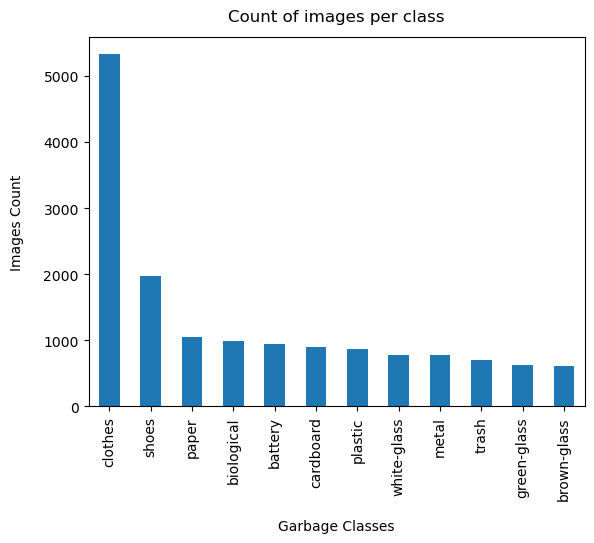

In [27]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

### Splitting Dataset into train, test and validation sets
We split the data set as follows: 80% train set, 10% cross_validation set, and 10% test set



In [28]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  2172 validate size =  2172 test size =  931


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size=64

train_datagen = ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [30]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 931 validated image filenames belonging to 12 classes.


In [31]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2172 validated image filenames belonging to 12 classes.


In [32]:
class_names = train_df.category.unique()
print(class_names)

['clothes' 'plastic' 'cardboard' 'shoes' 'battery' 'trash' 'paper'
 'white-glass' 'biological' 'brown-glass' 'green-glass' 'metal']


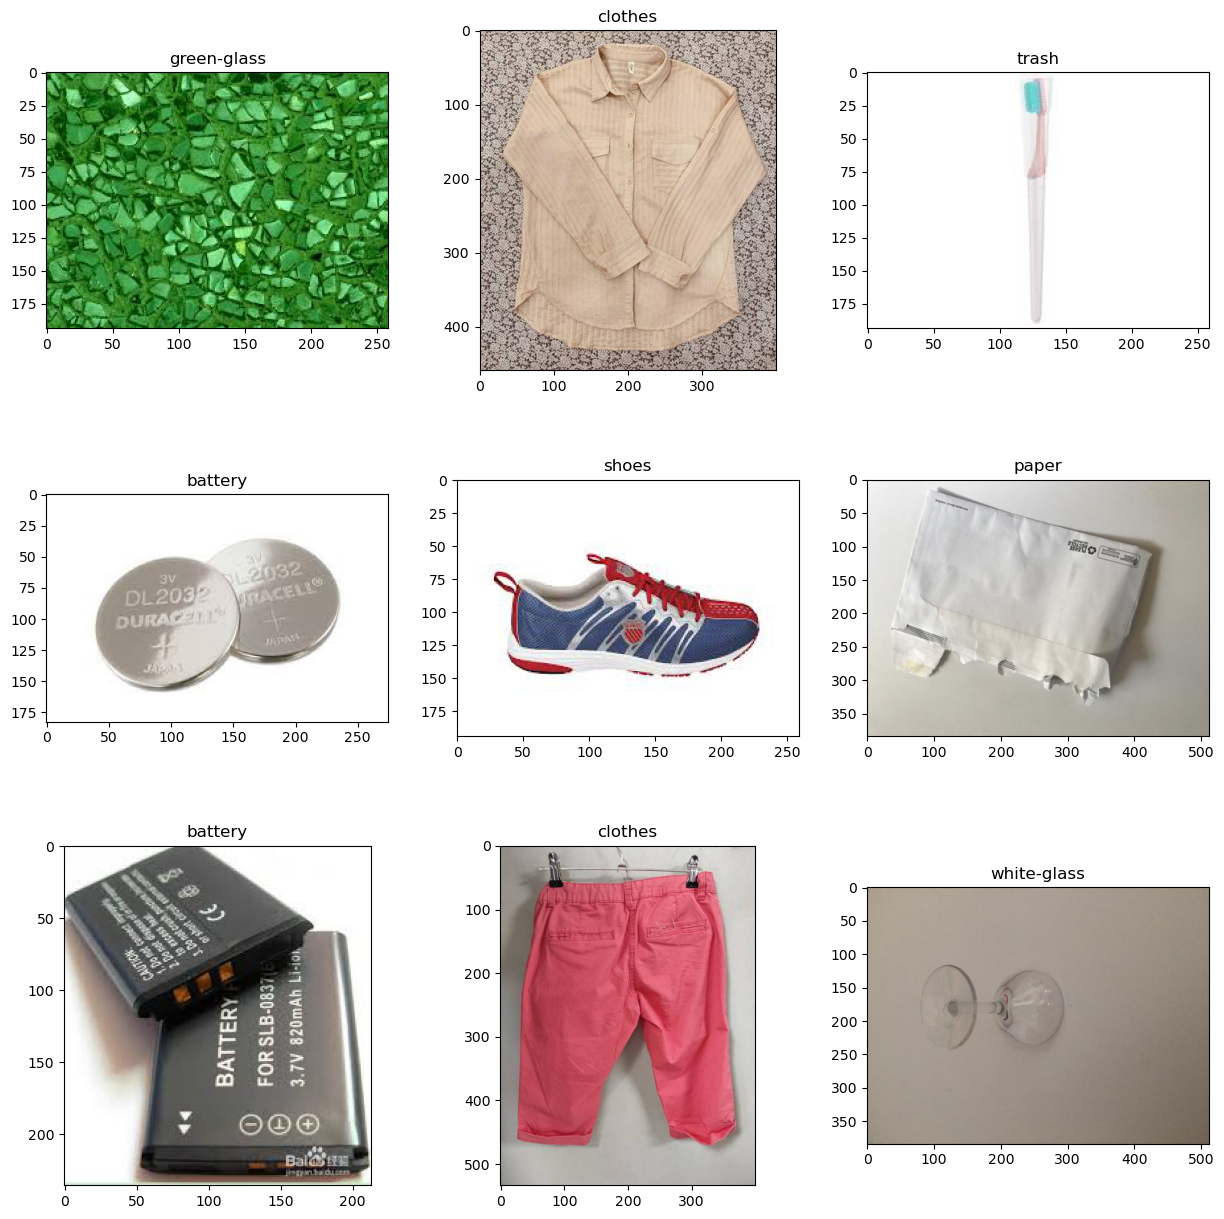

In [33]:
plt.figure(figsize=(15,15))
for i in range(9):
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    random_image = tf.keras.utils.load_img(base_path + sample['filename'])
    plt.subplot(330 + 1 + i)
    plt.title(sample['category'])
    plt.imshow(random_image)
plt.show()

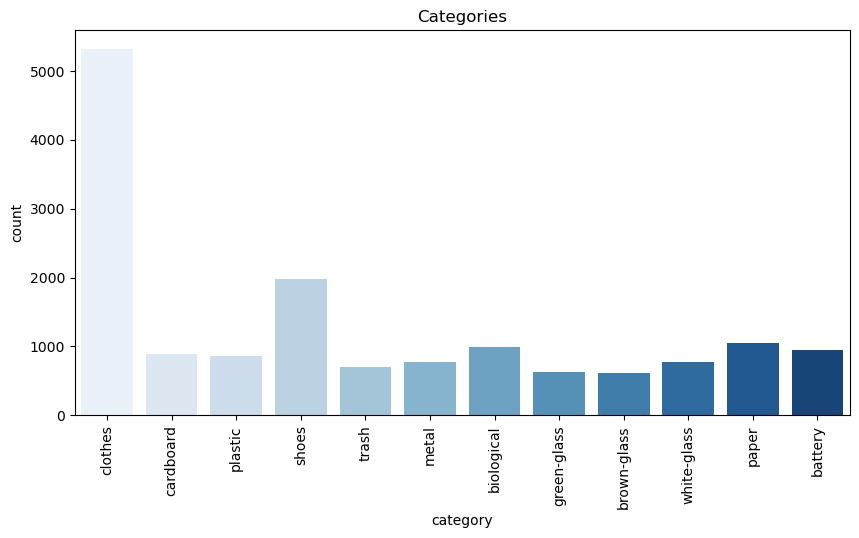

In [34]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(x="category", data=df, palette='Blues')
plt.xticks(rotation=90)
plt.title('Categories')
plt.show()

### Model Architecture
* **VGG-16 Base Model**

In [35]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [37]:
print_layer_trainable()


True:	input_2
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [38]:
base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False
     

In [39]:
print_layer_trainable()


False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [40]:
data_augmentation = keras.Sequential([
    #layers.CenterCrop(125, 125),
    keras.layers.RandomFlip('horizontal', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    keras.layers.RandomRotation(0.2, fill_mode = 'nearest'),
    keras.layers.RandomZoom(0.1),
])

In [41]:
n_classes = len(class_names)

model = Sequential([
    data_augmentation,
    keras.layers.Rescaling(1./255),
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(n_classes, activation = 'softmax')
])

### Transfer Learning

In [42]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

In [43]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [44]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [45]:
%%time
history = model.fit(train_generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/20
194/194 [==============================] - 319s 2s/step - loss: 1.7543 - accuracy: 0.4482 - val_loss: 1.1859 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 2/20
194/194 [==============================] - 228s 1s/step - loss: 1.3255 - accuracy: 0.5850 - val_loss: 0.9519 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 3/20
194/194 [==============================] - 226s 1s/step - loss: 1.1741 - accuracy: 0.6322 - val_loss: 0.8392 - val_accuracy: 0.7426 - lr: 0.0010
Epoch 4/20
194/194 [==============================] - 227s 1s/step - loss: 1.1000 - accuracy: 0.6599 - val_loss: 0.7778 - val_accuracy: 0.7468 - lr: 0.0010
Epoch 5/20
194/194 [==============================] - 227s 1s/step - loss: 1.0362 - accuracy: 0.6762 - val_loss: 0.7295 - val_accuracy: 0.7680 - lr: 0.0010
Epoch 6/20
194/194 [==============================] - 226s 1s/step - loss: 0.9885 - accuracy: 0.6892 - val_loss: 0.6867 - val_accuracy: 0.7827 - lr: 0.0010
Epoch 7/20
194/194 [==============================] - 227s 1s/st

### PLotting Accuracy and Loss

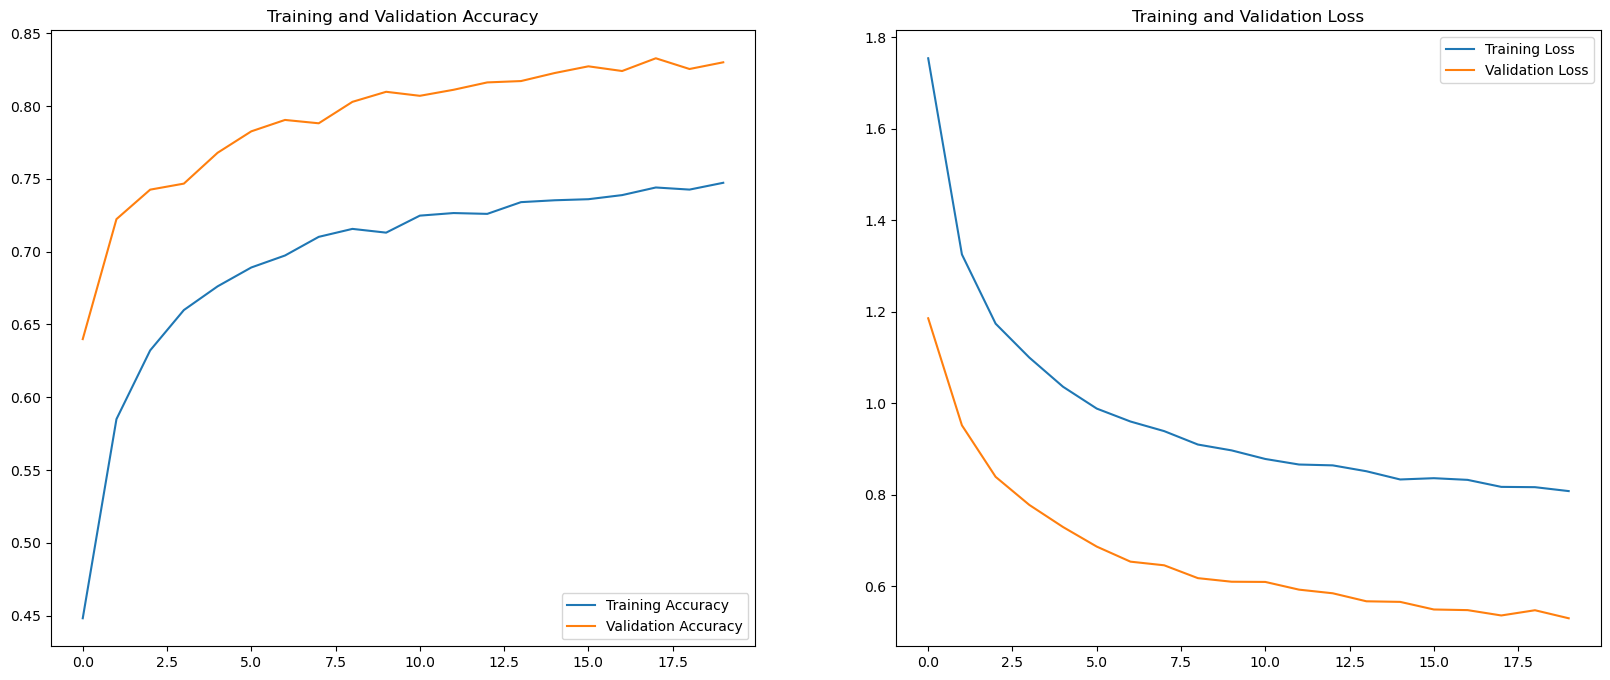

In [46]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [47]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 931 validated image filenames belonging to 12 classes.


In [48]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('Accuracy on test set = ',  round((accuracy * 100),2 ), '%')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


Accuracy on test set =  83.14 %


In [49]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [50]:
from sklearn.metrics import classification_report
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

     battery       0.82      0.95      0.88        58
  biological       0.98      0.82      0.90        74
 brown-glass       0.61      0.74      0.67        23
   cardboard       0.84      0.71      0.77        58
     clothes       0.88      0.97      0.92       326
 green-glass       0.93      0.74      0.82        34
       metal       0.54      0.68      0.60        37
       paper       0.80      0.68      0.73        59
     plastic       0.72      0.52      0.60        54
       shoes       0.87      0.93      0.90       119
       trash       0.86      0.68      0.76        47
 white-glass       0.59      0.57      0.58        42

    accuracy                           0.83       931
   macro avg       0.79      0.75      0.76       931
weighted avg       0.83      0.83      0.83       931



### FINE TUNING

In [51]:
fine_tune  = base_model
fine_tune.trainable = True

In [52]:
for layer in fine_tune.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [53]:
fine_tune.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [54]:
n_classes = len(class_names)

model2 = Sequential([
    data_augmentation,
    keras.layers.Rescaling(1./255),
    fine_tune,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(n_classes, activation = 'softmax')
])

In [55]:
model2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

In [56]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [57]:

# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights_fine_tuning.hdf5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

# References
1) https://www.toronto.ca/services-payments/recycling-organics-garbage/
2) https://www.sciencedirect.com/science/article/pii/S2351978919307231
3)https://www.researchgate.net/publication/346937517_Trash_Classification_Classifying_garbage_using_Deep_Learning

In [58]:
tf.keras.models.save_model(model2,'garbage_classification_model.hdf5')
